In [1]:
# Import the utility to load configuration
from utils.config_utils import load_config, ensure_directories

# Load the configuration file
config_path = "../config.yaml"  # Path to the configuration file
config = load_config(config_path)

# Access spatial transcriptomics settings
spatial_config = config["spatial_transcriptomics"]

# Extract key paths from the configuration
raw_data_dir = spatial_config["raw_data_dir"]
processed_data_dir = spatial_config["processed_data_dir"]
results_dir = spatial_config["results_dir"]
temp_dir = spatial_config["temp_dir"]

# Ensure required directories exist
ensure_directories(spatial_config, ["raw_data_dir", "processed_data_dir", "results_dir", "temp_dir"])

# Print configuration to verify
print("Spatial Transcriptomics Configuration:")
print(f"Raw Data Directory: {raw_data_dir}")
print(f"Processed Data Directory: {processed_data_dir}")
print(f"Results Directory: {results_dir}")
print(f"Temporary Directory: {temp_dir}")


Verified or created directory: /mnt/d/HNSC_Omics_Data/raw/GEO/GSE208253
Verified or created directory: /mnt/d/HNSC_Omics_Data/processed/Spatial_Transcriptomics
Verified or created directory: /mnt/d/HNSC_Omics_Data/results/Spatial_Transcriptomics
Verified or created directory: /mnt/d/HNSC_Omics_Data/temp/spatial_transcriptomics
Spatial Transcriptomics Configuration:
Raw Data Directory: /mnt/d/HNSC_Omics_Data/raw/GEO/GSE208253
Processed Data Directory: /mnt/d/HNSC_Omics_Data/processed/Spatial_Transcriptomics
Results Directory: /mnt/d/HNSC_Omics_Data/results/Spatial_Transcriptomics
Temporary Directory: /mnt/d/HNSC_Omics_Data/temp/spatial_transcriptomics


In [2]:
# Import libraries for analysis and visualization
import scanpy as sc
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pathlib import Path


In [3]:
# List all raw data files in the raw data directory
raw_files = list(Path(raw_data_dir).glob("*.h5"))
print(f"Found {len(raw_files)} raw spatial transcriptomics files.")

# Display the files
for file in raw_files:
    print(file.name)

# Load the first file for initial exploration
file_path = raw_files[0]
adata = sc.read_10x_h5(file_path)  # Load raw data using Scanpy
print(f"Loaded data from {file_path}")
print(adata)


Found 12 raw spatial transcriptomics files.
GSM6339631_s1_filtered_feature_bc_matrix.h5
GSM6339632_s2_filtered_feature_bc_matrix.h5
GSM6339633_s3_filtered_feature_bc_matrix.h5
GSM6339634_s4_filtered_feature_bc_matrix.h5
GSM6339635_s5_filtered_feature_bc_matrix.h5
GSM6339636_s6_filtered_feature_bc_matrix.h5
GSM6339637_s7_filtered_feature_bc_matrix.h5
GSM6339638_s8_filtered_feature_bc_matrix.h5
GSM6339639_s9_filtered_feature_bc_matrix.h5
GSM6339640_s10_filtered_feature_bc_matrix.h5
GSM6339641_s11_filtered_feature_bc_matrix.h5
GSM6339642_s12_filtered_feature_bc_matrix.h5
Loaded data from /mnt/d/HNSC_Omics_Data/raw/GEO/GSE208253/GSM6339631_s1_filtered_feature_bc_matrix.h5
AnnData object with n_obs × n_vars = 1185 × 36601
    var: 'gene_ids', 'feature_types', 'genome'


/home/secondbook5/micromamba/envs/HNSC_Omics/lib/python3.11/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/secondbook5/micromamba/envs/HNSC_Omics/lib/python3.11/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [4]:
# Make variable names unique to avoid downstream processing issues
adata.var_names_make_unique()
print("Variable names are now unique.")


Variable names are now unique.


Number of cells: 1185
Number of genes: 36601
Gene metadata:
                    gene_ids    feature_types  genome
MIR1302-2HG  ENSG00000243485  Gene Expression  GRCh38
FAM138A      ENSG00000237613  Gene Expression  GRCh38
OR4F5        ENSG00000186092  Gene Expression  GRCh38
AL627309.1   ENSG00000238009  Gene Expression  GRCh38
AL627309.3   ENSG00000239945  Gene Expression  GRCh38
Cell metadata:
Empty DataFrame
Columns: []
Index: [AAACACCAATAACTGC-1, AAACAGGGTCTATATT-1, AAACCGTTCGTCCAGG-1, AAACGAGACGGTTGAT-1, AAACTGCTGGCTCCAA-1]


/home/secondbook5/micromamba/envs/HNSC_Omics/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:234: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))


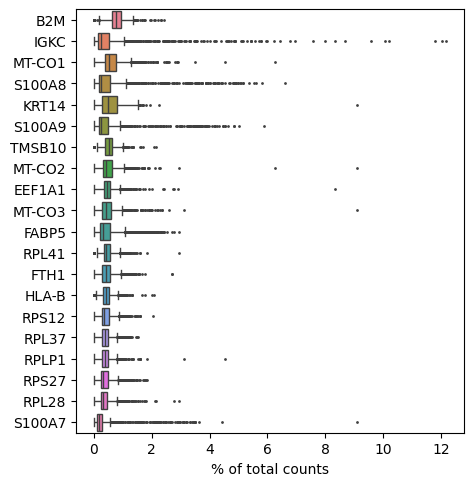

In [5]:
# Summary of the dataset
print(f"Number of cells: {adata.n_obs}")
print(f"Number of genes: {adata.n_vars}")

# View metadata about genes (variables)
print("Gene metadata:")
print(adata.var.head())

# View metadata about cells (observations)
print("Cell metadata:")
print(adata.obs.head())

# Visualize the total counts for each cell
sc.pl.highest_expr_genes(adata, n_top=20)  # Plot the most expressed genes


In [6]:
# Step 1: Filter out low-quality genes and cells
sc.pp.filter_genes(adata, min_cells=3)  # Keep genes expressed in at least 3 cells
sc.pp.filter_cells(adata, min_genes=200)  # Keep cells expressing at least 200 genes

# Step 2: Normalize the total counts per cell
sc.pp.normalize_total(adata, target_sum=1e4)

# Step 3: Log-transform the data
sc.pp.log1p(adata)

# Save preprocessed data
preprocessed_path = Path(processed_data_dir) / "GSM6339631_processed.h5ad"
adata.write(preprocessed_path)
print(f"Preprocessed data saved to: {preprocessed_path}")


Preprocessed data saved to: /mnt/d/HNSC_Omics_Data/processed/Spatial_Transcriptomics/GSM6339631_processed.h5ad


In [7]:
# Visualize expression of a specific gene
sc.pl.violin(adata, ['Gene1', 'Gene2'], groupby='feature_types', jitter=0.4, multi_panel=True)

# Compute PCA for dimensionality reduction
sc.tl.pca(adata)
sc.pl.pca_variance_ratio(adata, log=True)

# Compute and visualize UMAP
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)
sc.pl.umap(adata, color=["Gene1", "Gene2"])


KeyError: "Could not find keys '['feature_types', 'Gene1', 'Gene2']' in columns of `adata.obs` or in adata.var_names."